In [2]:
import h5py
import pandas as pd
import numpy as np
'''
def explore_hdf5(group, prefix=''):
    """Recursively explore an HDF5 group/dataset."""
    if isinstance(group, h5py.Dataset):
        print(prefix + 'Dataset:', group.name)
        print(prefix + 'Shape:', group.shape)
        print(prefix + 'Type:', group.dtype)
    elif isinstance(group, h5py.Group):
        print(prefix + 'Group:', group.name)
        for key in group:
            explore_hdf5(group[key], prefix + '  ')

filename = '/honey/nmep/medium-imagenet-96.hdf5'
with h5py.File(filename, 'r') as f:
    explore_hdf5(f)

'''

'''
# Open the HDF5 file
with h5py.File('/honey/nmep/medium-imagenet-96.hdf5', 'r') as f:
    # Extract datasets
    images_test = f['/images-test'][:]
    images_train = f['/images-train'][:]
    images_val = f['/images-val'][:]
    labels_train = f['/labels-train'][:]
    labels_val = f['/labels-val'][:]
    
# Convert datasets to pandas DataFrames
# Note: For the images, you might want to reshape or process them differently based on your needs.
# Here, I'm just converting them into a DataFrame with each image flattened as an example.

df_images_test = pd.DataFrame(images_test.reshape(images_test.shape[0], -1))
df_images_train = pd.DataFrame(images_train.reshape(images_train.shape[0], -1))
df_images_val = pd.DataFrame(images_val.reshape(images_val.shape[0], -1))
df_labels_train = pd.DataFrame(labels_train, columns=['label'])
df_labels_val = pd.DataFrame(labels_val, columns=['label'])
'''

In [ ]:
'''
Structure:
  Dataset: /images-test
  Shape: (75929, 3, 96, 96)
  Type: uint8

  
  Dataset: /images-train
  Shape: (607425, 3, 96, 96)
  Type: uint8
  Dataset: /images-val
  Shape: (75928, 3, 96, 96)
  Type: uint8
  Dataset: /labels-train
  Shape: (607425,)
  Type: uint8
  Dataset: /labels-val
  Shape: (75928,)
  Type: uint8
'''

In [18]:
'''
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.models import resnet18
from torchvision.transforms import transforms
import pandas as pd


# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ResNet-18 model
model = resnet18(pretrained=True)  # Load the pre-trained weights from ImageNet

# Adjust the final layer to match the number of classes in your dataset (200 in this case)
model.fc = nn.Linear(model.fc.in_features, 200)  # 200 categories

# Move the model to the chosen device
model = model.to(device)


# Convert DataFrames to PyTorch Datasets
X_train = torch.tensor(df_images_train.values, dtype=torch.float32).reshape(-1, 3, 96, 96)
y_train = torch.tensor(df_labels_train.values, dtype=torch.long).squeeze()
train_dataset = TensorDataset(X_train, y_train)

X_val = torch.tensor(df_images_val.values, dtype=torch.float32).reshape(-1, 3, 96, 96)
y_val = torch.tensor(df_labels_val.values, dtype=torch.long).squeeze()
val_dataset = TensorDataset(X_val, y_val)

X_test = torch.tensor(df_images_test.values, dtype=torch.float32).reshape(-1, 3, 96, 96)
test_dataset = TensorDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ... [rest of the model initialization and training code]

# After training, generate predictions for the test set
model.eval()
ids = []
predictions = []

# After training, generate predictions for the test set
model.eval()
ids = []
predictions = []

with torch.no_grad():
    for idx, (images,) in enumerate(test_loader):  # Only images, no labels
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        batch_ids = list(range(idx * 32 + 1, idx * 32 + len(images) + 1))
        ids.extend(batch_ids)
        predictions.extend(predicted.cpu().numpy())

# Save predictions to CSV
df_test_predictions = pd.DataFrame({
    'Id': ids,
    'Category': predictions
})
df_test_predictions.to_csv('predictions.csv', index=False)
'''

In [3]:
'''
import os.path
path = "/honey/nmep/medium-imagenet-96.hdf5"
check_file = os.path.isfile(path)
print(check_file)
'''

True


In [6]:
'''
# Import necessary modules
import h5py
import torch
from torchvision import transforms
from datasets import MediumImagenetHDF5Dataset

img_size = 224
dataset = MediumImagenetHDF5Dataset(img_size=img_size, split="train")
index = 0
data, label = dataset.__getitem__(0)
'''

/images-train


/home/terrykim1211/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


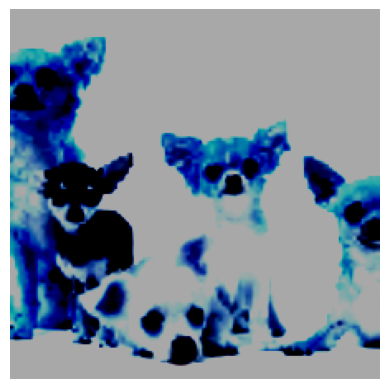

In [14]:
#Visualize Data
import matplotlib.pyplot as plt

# Assuming 'image' is your tensor of size [3, 224, 224]
image_np = data.permute(1, 2, 0).numpy()  # Convert to HxWxC format
plt.imshow(image_np)
plt.axis('off')  # Hide axes
plt.show()

In [1]:
import pandas as pd
import torch
from models.resnet import ResNet18

In [2]:
data = pd.read_csv("/honey/nmep/test_labels_kaggle.csv")
print(data[0])

PermissionError: [Errno 13] Permission denied: '/honey/nmep/test_labels_kaggle.csv'

In [7]:
#Read csv file and predict

device = torch.device('cpu' if torch.cuda.is_available() else 'gpu')

model = ResNet18()
model.load_state_dict(torch.load('/home/terrykim1211/nmep/sp23-nmep-hw1/output/resnet18/ckpt_best.pth'))

model = model.to(device) # Set model to gpu
model.eval()

inputs = torch.random.randn(1, 3, 224, 224) # Dtype is fp32
inputs = inputs.to(device) # You can move your input to gpu, torch defaults to cpu

# Run forward pass
with torch.no_grad():
  pred = model(inputs)

# Do something with pred
pred = pred.detach().cpu().numpy() # remove from computational graph to cpu and as numpy


<bound method Module.parameters of LeNet(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=200, bias=True)
  )
)>
Number of parameters: 99276


In [ ]:
@torch.no_grad()
def evaluate(config, data_loader, model):
    model.eval()
    preds = []
    for idx, (images, _) in enumerate(tqdm(data_loader)):
        images = images.cuda(non_blocking=True)
        output = model(images)
        preds.append(output.cpu().numpy())
    preds = np.concatenate(preds)
    return preds

In [13]:
import numpy as np

def softmax(logits):
    """Compute softmax values for each sets of scores in logits."""
    # Ensure that the logits are in float type
    logits = np.array(logits, dtype=np.float32)
    # Compute the exponentials of the logits
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    # Compute the softmax values
    softmax_values = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    return softmax_values

def predict_class(softmax_probs):
    """Predict the class index based on softmax probabilities."""
    return np.argmax(softmax_probs, axis=1)


predictions = np.load('/home/terrykim1211/nmep/sp23-nmep-hw1/output/resnet18/preds.npy')
predictions = predict_class(predictions)

In [14]:
predictions

array([ 28, 121,  65, ..., 133,  77,  34])

In [15]:
import csv
# Open a new CSV file in write mode
with open('/home/terrykim1211/nmep/sp23-nmep-hw1/prediction_kaggle.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile) 
    # Write the headers
    writer.writerow(["Id", "Category"])
    # Write the class values
    for index, value in enumerate(predictions):
        writer.writerow([index, value])

In [16]:
submission = pd.read_csv('/home/terrykim1211/nmep/sp23-nmep-hw1/prediction_kaggle.csv')
print(submission)

          Id  Category
0          0        28
1          1       121
2          2        65
3          3        48
4          4       165
...      ...       ...
75924  75924       110
75925  75925        37
75926  75926       133
75927  75927        77
75928  75928        34

[75929 rows x 2 columns]
